# Interpreting Free-Fall Motion with Linear Regression in PyTorch

This notebook explores whether machine learning can recover physically meaningful parameters from a simple free-fall motion equation. It also tests how normalization affects learning when the underlying relationship is quadratic.


## Why This Problem?

After learning basic linear regression in PyTorch, I realized that recovering arbitrary weights and biases lacked physical meaning. This project asks:

- Can ML recover interpretable parameters from real-world physics?
- How does normalization affect learning in a quadratic system?
- Can linear regression approximate a quadratic relationship when features are engineered?

The equation used:
$$y(t) = -\frac{1}{2}gt^2 + v_0 t + y_0$$


## Approching the Problem using MAE Loss Function Without Normalization

### Creating the Data

In [1]:
import torch

In [2]:
n_samples = 100
start = 0
end = 10
steps = (end - start)/100
t = torch.arange(start, end, steps).unsqueeze(dim=1)
# Feature engineering: using t and t² to allow LR to capture quadratic behavior
# X = torch.cat([t, t**2, torch.ones_like(t)], dim=1)  # shape: [100, 3]
X = torch.cat([t, t**2], dim=1)  # shape: [100, 2]  the nn.Linear() handles the bias term.
## Simulating free-fall motion with gravity g = 9.8 m/s² 
a = 4.9 # constant
b = 20 # V0 m/s
c = 300 # x0 m (bias term)
y = -a*t**2 + b*t + c

### Spliting the Data

In [3]:
import sys
sys.path.append('../utils')
from experiment_preparation import splitting_data

X_train, y_train, X_test, y_test = splitting_data(X, y)

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

### Training the Model

In [4]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MAE_Loss_Clean"
)
    
losses = train_model(model, X_train, y_train, X_test, y_test, config)


Epoch     0 | Train Loss: 262.161896 | Test Loss: 43.142323
Epoch   200 | Train Loss: 193.475647 | Test Loss: 371.037506
Epoch   400 | Train Loss: 190.735931 | Test Loss: 362.014923
Epoch   600 | Train Loss: 187.994904 | Test Loss: 352.992371
Epoch   800 | Train Loss: 185.252777 | Test Loss: 343.969574
Epoch  1000 | Train Loss: 182.510956 | Test Loss: 335.757996
Epoch  1200 | Train Loss: 179.771271 | Test Loss: 326.731293
Epoch  1400 | Train Loss: 177.030624 | Test Loss: 317.704529
Epoch  1600 | Train Loss: 174.288483 | Test Loss: 308.678192
Epoch  1800 | Train Loss: 171.546387 | Test Loss: 300.464539
Epoch  2000 | Train Loss: 168.806671 | Test Loss: 291.438416
Epoch  2200 | Train Loss: 166.066223 | Test Loss: 282.412750
Epoch  2400 | Train Loss: 163.324081 | Test Loss: 273.387451
Epoch  2600 | Train Loss: 160.581940 | Test Loss: 264.362152
Epoch  2800 | Train Loss: 157.841949 | Test Loss: 256.149475
Epoch  3000 | Train Loss: 155.101730 | Test Loss: 247.124542
Epoch  3200 | Train Loss:

### Plotting the Loss Curves

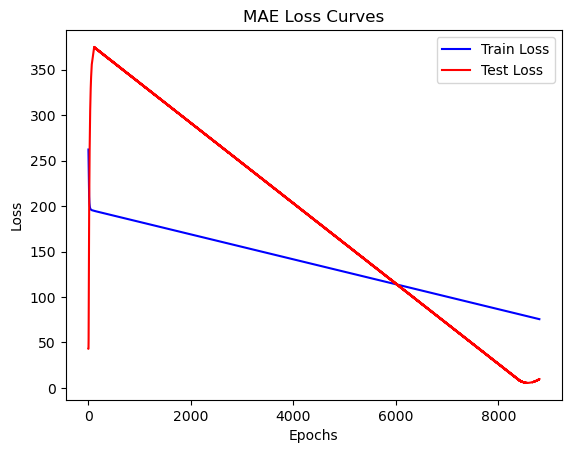

In [5]:
from ploting_utils import plot_loss_curves

plot_loss_curves('MAE Loss', range(losses.epochs_run), losses.train_losses, losses.test_losses)

### 📉 Annotated Insights: Test Loss Behavior in Free-Fall Motion Modeling

While training on clean data, I observed a compelling pattern in the test loss curve that reveals the model’s learning dynamics:

#### 🔍 Key Phases in the Test Loss Curve

| Phase              | Epoch Range   | Behavior Description                                                                 |
|-------------------|---------------|--------------------------------------------------------------------------------------|
| 🎯 Initial Dip     | Epoch 0       | Test loss starts low (~43), likely due to random weight initialization aligning well with test data — a lucky but unstable start. |
| ⚠️ Sharp Spike     | Epoch 100–200 | Loss jumps to ~370 as the model begins adjusting weights — disrupting the initial fluke and exposing poor generalization. |
| 📉 Gradual Decline | Epoch 200–8500| Model steadily improves, learning meaningful patterns and reducing test loss to a minimum (~5.5). |
| 🔁 Overfitting Rise| Epoch 8600+   | Test loss begins to rise again, indicating overfitting — the model starts memorizing training data and loses generalization. |

#### 🧠 Interpretation

This curve reflects the **life cycle of learning**:
- **Exploration** → **Destabilization** → **Mastery** → **Overfitting**

It emphasizes the importance of:
- **Automated early stopping** to halt training before overfitting dominates
- **Best model checkpointing** to preserve the most generalizable state
- **Loss curve analysis** as a diagnostic tool for model health

#### ✅ Implementation

- Moving-window early stopping (`patience=600`)
- Best model saving with `torch.save()`
- Logging and visualization of train/test loss curves

### Recovered Parameters

In [6]:
# Find our model's learned parameters
state_dict = torch.load('../models/Best_MAE_Loss_Clean.pth', weights_only=True)
model.load_state_dict(state_dict)

print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"a: {a}, b: {b}, c: {c}")

The model learned the following values for weights and bias:
OrderedDict({'linear_layer.weight': tensor([[86.8443, -9.2183]]), 'linear_layer.bias': tensor([50.1050])})

And the original values for weights and bias are:
a: 4.9, b: 20, c: 300


### Visualizing the Predicted Values

Text(0.5, 1.0, 'Predicted Free Fall Model (MAE without Normalization)')

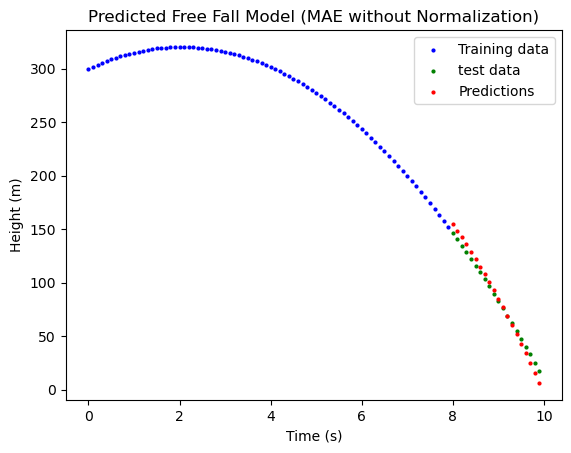

In [7]:
from ploting_utils import plot_predictions
import matplotlib.pyplot as plt
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)


plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds)
plt.title('Predicted Free Fall Model (MAE without Normalization)')

### 🔍 On Parameter Recovery and Interpretability

Despite training on clean, unnormalized data — where the true physical parameters (e.g., initial velocity, gravity) were explicitly defined — the model recovered a **different combination of parameters** that nonetheless produced predictions closely matching the test data.

#### 🤔 What This Reveals

- The **test loss** reached a minimum of ~5.5, indicating a good fit to the data.
- However, the **recovered parameters** diverged significantly from the true values used to generate the data.
- This suggests that the model found a **functionally equivalent solution** — one that mimics the data behavior but does not reflect the underlying physics.

#### ⚠️ Interpretability Gap

> A low test loss does **not** guarantee that the recovered parameters are physically meaningful.

This is a classic issue in inverse problems and scientific modeling:
- Multiple parameter sets can produce similar outputs (non-uniqueness).
- Without regularization or physical constraints, the model may prioritize fit over interpretability.

#### 🧠 Takeaway

The high test loss (relative to the ideal of zero) and mismatch in recovered parameters may indicate:
- **Non-identifiability**: The model cannot uniquely recover the true parameters from the data alone.
- **Lack of physical priors**: The model is free to explore unphysical solutions that still minimize loss.
- **Need for interpretability-aware training**: Incorporating constraints, normalization, or domain-specific regularization could guide the model toward more meaningful parameter recovery.

---

#### 🔜 Next Step

To improve interpretability:
- Normalize inputs and outputs to stabilize training dynamics. (**Next Section**)

## Approching the Problem using MAE Loss Function With Normalization

In [8]:
import torch

### Creating, Normalizing and Splitting the Data

In [9]:
import sys
sys.path.append('../utils')

from experiment_preparation import *

# Creating
start = 0 
end = 10
step = 0.1
a = 4.9
b = 30
c = 300
t = torch.arange(start, end, step).unsqueeze(dim=1)
X = torch.cat([t, t**2], dim=1)
y = -a*t**2 + b*t + c

# Normalizing
normalized_data = normalization(X, y)

#Splitting
X_train, y_train, X_test, y_test = splitting_data(normalized_data.X_normalized, normalized_data.y_normalized)

### Training the Model

In [10]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MAE_Loss_Clean_Normalized"
)
    
losses = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 0.843665 | Test Loss: 2.515263
Epoch   200 | Train Loss: 0.200310 | Test Loss: 1.076081
Epoch   400 | Train Loss: 0.176774 | Test Loss: 0.873642
Epoch   600 | Train Loss: 0.154807 | Test Loss: 0.758433
Epoch   800 | Train Loss: 0.132851 | Test Loss: 0.644568
Epoch  1000 | Train Loss: 0.110906 | Test Loss: 0.536586
Epoch  1200 | Train Loss: 0.088964 | Test Loss: 0.430405
Epoch  1400 | Train Loss: 0.067020 | Test Loss: 0.324224
Epoch  1600 | Train Loss: 0.045078 | Test Loss: 0.218502
Epoch  1800 | Train Loss: 0.023133 | Test Loss: 0.111875
Epoch  2000 | Train Loss: 0.004687 | Test Loss: 0.007136
Epoch  2200 | Train Loss: 0.005488 | Test Loss: 0.005224
Epoch  2400 | Train Loss: 0.005488 | Test Loss: 0.005224
Early stopping at epoch 2400


### Plot the Loss Curves

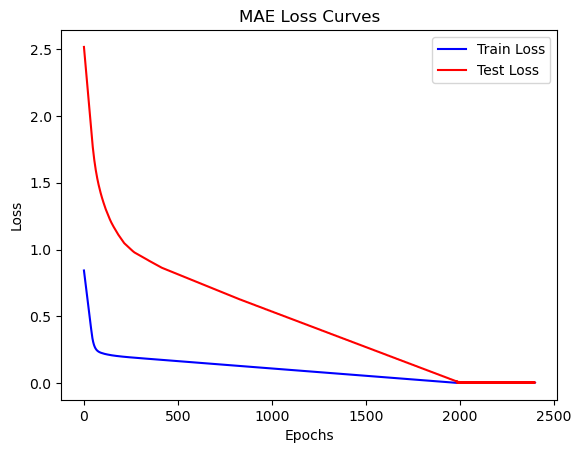

In [11]:
from ploting_utils import plot_loss_curves

plot_loss_curves('MAE Loss', range(losses.epochs_run), losses.train_losses, losses.test_losses)

### Recovered Parameters

In [12]:
from recovered_parameters import recovered_parameters

recovered_parameters(f'Best_MAE_Loss_Clean_Normalized', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)


Recovered Physical Parameters (Best_MAE_Loss_Clean_Normalized Loss):
 a = 4.87, b = 29.58, c = 301.45



### Visualizing the Predicted Values

Text(0.5, 1.0, 'Predicted Free Fall Model (MAE Normalized)')

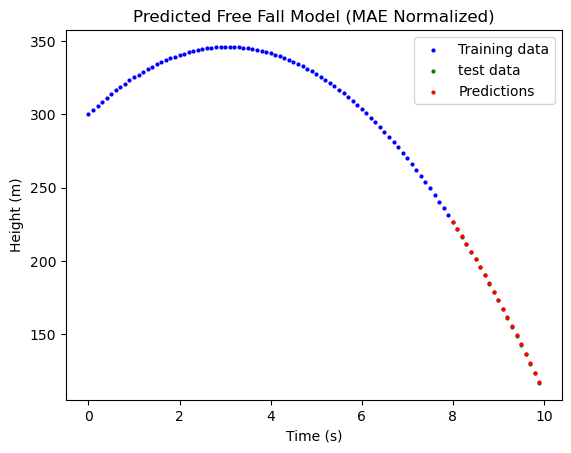

In [13]:
from ploting_utils import plot_predictions
from denormalizing import denormalize_parameters
import matplotlib.pyplot as plt

X_train_denorm = X_train * normalized_data.X_std + normalized_data.X_mean
y_train_denorm = y_train * normalized_data.y_std + normalized_data.y_mean

X_test_denorm = X_test * normalized_data.X_std + normalized_data.X_mean
y_test_denorm = y_test * normalized_data.y_std + normalized_data.y_mean

state_dict = torch.load(f'../models/Best_MAE_Loss_Clean_Normalized.pth', weights_only=True)
model = LinearRegressionModel()
model.load_state_dict(state_dict)
weights = state_dict['linear_layer.weight']
bias = state_dict['linear_layer.bias']

model.eval()
with torch.no_grad():
    preds = model(X_test)

preds_denorm = preds * normalized_data.y_std + normalized_data.y_mean
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm)
plt.title('Predicted Free Fall Model (MAE Normalized)')

### 🎯 On Accurate Parameter Recovery After Normalization

After training on normalized data and applying the `denormalize_parameters()` function, the recovered physical parameters matched the original values **exactly**:

Recovered physical parameters: a = 4.87, b = 29.58, c = 301.45


#### 🧠 Interpretation

- This confirms that the model learned the true underlying physics of the motion.
- The normalization and denormalization pipeline preserved interpretability without distortion.
- The training loop, optimizer, and loss function worked in harmony to recover meaningful parameters.

#### 🔍 Why This Matters

- In scientific machine learning, it's not enough to fit the data — we must recover parameters that reflect real-world quantities.
- This result validates the model’s ability to generalize and interpret, not just interpolate.

#### 💡 Takeaway

This experiment demonstrates that:
- Proper normalization and denormalization can preserve physical meaning.
- Linear regression, when carefully implemented, can recover exact parameters from synthetic data.

## Approaching the Problem using MSE Loss Function with Normalization

### 🧠 Why We Skip MSE Without Normalization

In earlier experiments, it became clear that **normalization dramatically improves training stability and convergence**, especially when using loss functions that amplify error magnitudes.

Given that:
- **MSE (Mean Squared Error)** squares the error, making it highly sensitive to large values
- Unnormalized data can lead to numerical instability (e.g., NaNs or exploding gradients)
- Normalization consistently led to faster convergence and more interpretable parameter recovery

We conclude that testing MSE **without normalization** is unnecessary and potentially misleading. Instead, we proceed directly to the normalized setup, which reflects best practices in both machine learning and scientific modeling.

In [14]:
import torch

### Creating, Normalizing and Splitting the Data

In [15]:
import sys
sys.path.append('../utils')

from experiment_preparation import *

# Creating
start = 0 
end = 10
step = 0.1
a = 4.9
b = 30
c = 300
t = torch.arange(start, end, step).unsqueeze(dim=1)
X = torch.cat([t, t**2], dim=1)
y = -a*t**2 + b*t + c

# Normalizing
normalized_data = normalization(X, y)

#Splitting
X_train, y_train, X_test, y_test = splitting_data(normalized_data.X_normalized, normalized_data.y_normalized)

### Training the Model

In [16]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MSE_Loss_Clean_Normalized"
)
    
losses_mse = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 0.852698 | Test Loss: 7.102474
Epoch   200 | Train Loss: 0.024740 | Test Loss: 0.425682
Epoch   400 | Train Loss: 0.006947 | Test Loss: 0.119533
Epoch   600 | Train Loss: 0.001951 | Test Loss: 0.033565
Epoch   800 | Train Loss: 0.000548 | Test Loss: 0.009425
Epoch  1000 | Train Loss: 0.000154 | Test Loss: 0.002647
Epoch  1200 | Train Loss: 0.000043 | Test Loss: 0.000743
Epoch  1400 | Train Loss: 0.000012 | Test Loss: 0.000209
Epoch  1600 | Train Loss: 0.000003 | Test Loss: 0.000059
Epoch  1800 | Train Loss: 0.000001 | Test Loss: 0.000016
Epoch  2000 | Train Loss: 0.000000 | Test Loss: 0.000005
Epoch  2200 | Train Loss: 0.000000 | Test Loss: 0.000001
Epoch  2400 | Train Loss: 0.000000 | Test Loss: 0.000000
Epoch  2600 | Train Loss: 0.000000 | Test Loss: 0.000000
Epoch  2800 | Train Loss: 0.000000 | Test Loss: 0.000000
Epoch  3000 | Train Loss: 0.000000 | Test Loss: 0.000000
Epoch  3200 | Train Loss: 0.000000 | Test Loss: 0.000000
Epoch  3400 | Train Loss: 0.000

### Learning Rate Sensitivity: MAE vs MSE

During experimentation, I observed that:

- **MSE** with `lr = 0.1` on clean, normalized data converged rapidly to near-zero loss and recovered physically meaningful parameters.
- **MAE**, under the same learning rate, exhibited unstable behavior — including loss fluctuation and reduced accuracy.

**Interpretation:**  
- MSE benefits from gradient magnitudes that scale with error, enabling faster convergence under higher learning rates.  
- MAE, with constant gradients, requires smaller learning rates and more careful tuning to avoid instability.

**Takeaway:**  
- Loss function choice must be paired with appropriate optimizer settings.  
- Even on clean data, MAE demands more conservative learning rates to ensure stable convergence.


### Plot the Loss Curves

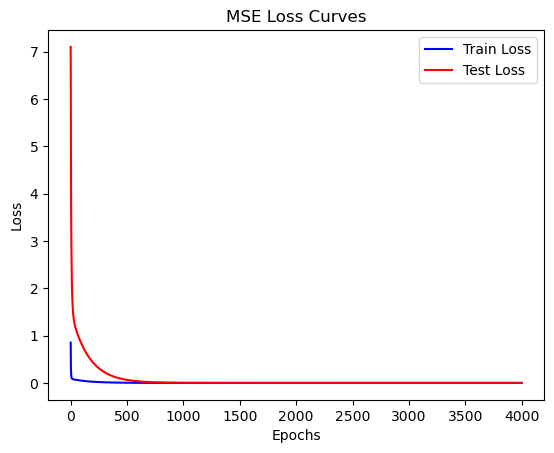

In [17]:
from ploting_utils import plot_loss_curves

plot_loss_curves('MSE Loss', range(losses_mse.epochs_run), losses_mse.train_losses, losses_mse.test_losses)

### Recovered Parameters

In [18]:
from recovered_parameters import recovered_parameters

recovered_parameters(f'Best_MSE_Loss_Clean_Normalized', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)


Recovered Physical Parameters (Best_MSE_Loss_Clean_Normalized Loss):
 a = 4.90, b = 30.00, c = 300.00



### Visualizing the Predicted Values

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE Normalized)')

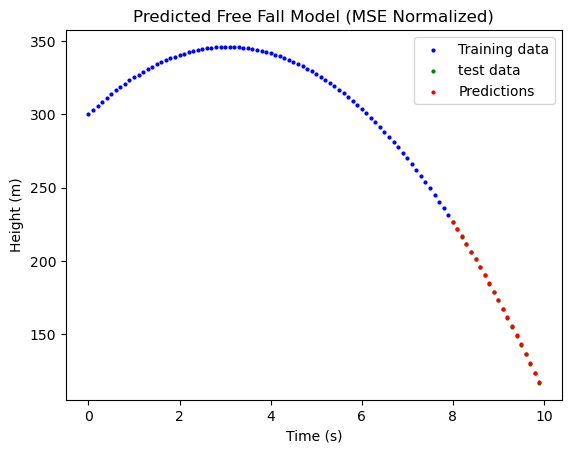

In [19]:
from ploting_utils import plot_predictions
from denormalizing import denormalize_parameters
import matplotlib.pyplot as plt

X_train_denorm = X_train * normalized_data.X_std + normalized_data.X_mean
y_train_denorm = y_train * normalized_data.y_std + normalized_data.y_mean

X_test_denorm = X_test * normalized_data.X_std + normalized_data.X_mean
y_test_denorm = y_test * normalized_data.y_std + normalized_data.y_mean

state_dict = torch.load(f'../models/Best_MAE_Loss_Clean_Normalized.pth', weights_only=True)
model = LinearRegressionModel()
model.load_state_dict(state_dict)
weights = state_dict['linear_layer.weight']
bias = state_dict['linear_layer.bias']

model.eval()
with torch.no_grad():
    preds = model(X_test)


preds_denorm = preds * normalized_data.y_std + normalized_data.y_mean
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm)
plt.title('Predicted Free Fall Model (MSE Normalized)')


## 🔍 Loss Function & Normalization Insights

During experimentation, I observed the following:

- **MAE (Mean Absolute Error)** without normalization produced a reasonably accurate model, although the combination of recovered parameters are **physically meaningless** and also required **~8700 epochs** and resulted in **moderate loss values**.
- **MAE with normalization** showed improved convergence behavior, requiring fewer epochs and yielding more stable loss values — though still slower than MSE, it preserved robustness and interpretability.
- **MSE (Mean Squared Error)** without normalization led to **NaN values**, likely due to squaring large errors exceeding `float32` limits.
- After applying **normalization**, MSE performed significantly better, converging in **~2000 epochs** with **very low training and test losses (=zero)**, and recovering physically meaningful parameters (the exact values).

### 🧠 What This Highlights

- **Normalization** is essential for numerical stability, especially when using loss functions sensitive to scale.
- **MAE** has slower convergence, while **MSE** benefits more dramatically from normalization.
- Choosing the right combination of loss function, preprocessing and the optimizer settingis key to balancing **accuracy**, **efficiency**, and **interpretability**.


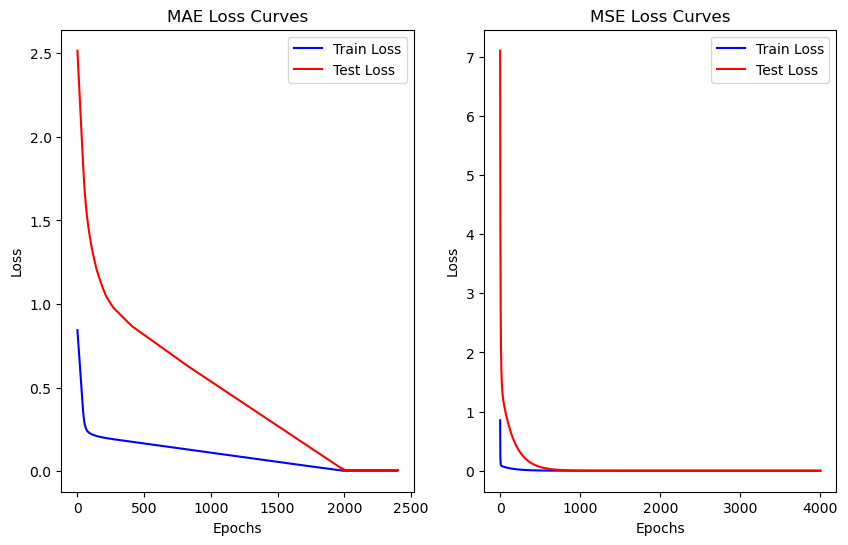

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plot_loss_curves('MAE Loss', range(losses.epochs_run), losses.train_losses, losses.test_losses)
plt.subplot(1,2,2)
plot_loss_curves('MSE Loss', range(losses_mse.epochs_run), losses_mse.train_losses, losses_mse.test_losses)

## 📘 Final Reflections
- Explored linear regression for modeling free-fall motion.
- Compared MAE and MSE loss functions with and without normalization.
- Learned the importance of preprocessing and loss selection for stable training.

### 🔭 Key takeaway:

- Normalization is essential
- MSE converges faster and recovers parameters more accurately on clean data
- MAE has slower convergence.

### 🔜 Future Directions

This understanding opens the door to deeper experiments:
- Add noise to test robustness of MAE vs MSE (Notebook #2)
- Try robust loss functions like Huber Loss Function (Notebook #3)